# Computing the betas

In order to compute the beta for both Stellantis and Walmart we took S&P 500 as benchmark.

To compute the beta for each company over the past 5 years, we will:

- Sort the data by date (in ascending order).

- Convert prices to monthly returns.

- Align returns by date across the 3 datasets.

- Perform linear regression of company returns on S&P 500 returns to compute beta.

### 4. **Run Linear Regressions**

To estimate beta for each stock, we run an Ordinary Least Squares (OLS) regression of the stock's returns against the market returns (S&P 500). The regression equation is:

$$ r_{stock} = \alpha + \Beta \times r_{market} + \epsilon $$


Where:
- $r_{stock}$ is the return of the stock (e.g., Walmart or Stellantis)  
- $r_{market}$ is the return of the market (S&P 500)  
- $\beta$ represents the stock’s **systematic risk** (sensitivity to the market)  
- $\alpha$ is the intercept (often interpreted as abnormal return or "alpha")  
- $\epsilon$ is the error term  

The **slope coefficient (β)** from this regression is the **beta of the stock**. It tells us how much the stock’s return changes in response to changes in the market return.



In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

# Load the datasets
walmart_df = pd.read_csv('Dataset/Walmart Stock Price History.csv')
stellantis_df = pd.read_csv('Dataset/Stellantis NV Stock Price History.csv')
sp500_df = pd.read_csv('Dataset/S&P 500 Historical Data.csv')


In [4]:
def clean_dataframe(df):
    """
    Cleans the input DataFrame by performing the following operations:
    - Converts the 'Price' column to a float after removing commas.
    - Converts the 'Date' column to datetime format.
    - Sorts the DataFrame by the 'Date' column in ascending order.
    - Calculates the percentage change in the 'Price' column and adds it as a new column named 'Return'.
    """
    
    df['Price'] = df['Price'].astype(str).str.replace(',', '', regex=False).astype(float)
    df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
    df.sort_values('Date', inplace=True)
    df['Return'] = df['Price'].pct_change()
    return df

# Clean the dataframes
walmart_df = clean_dataframe(walmart_df)
stellantis_df = clean_dataframe(stellantis_df)
sp500_df = clean_dataframe(sp500_df)

In [ ]:
# Align the returns data by date
returns_df = pd.merge(walmart_df[['Date', 'Return']], 
                      stellantis_df[['Date', 'Return']], 
                      on='Date', suffixes=('_Walmart', '_Stellantis'))
returns_df = pd.merge(returns_df, 
                      sp500_df[['Date', 'Return']], 
                      on='Date')
returns_df.rename(columns={'Return': 'Return_SP500'}, inplace=True)
returns_df.dropna(inplace=True)

X = returns_df[['Return_SP500']].values

y_walmart = returns_df['Return_Walmart'].values
beta_walmart = LinearRegression().fit(X, y_walmart).coef_[0]

y_stellantis = returns_df['Return_Stellantis'].values
beta_stellantis = LinearRegression().fit(X, y_stellantis).coef_[0]

print("Walmart Beta:", beta_walmart)
print("Stellantis Beta:", beta_stellantis)


Walmart Beta: 0.715925060481918
Stellantis Beta: 1.4189254625252332


## Risk Interpretation:
### Walmart (β ≈ 0.72):

- Less volatile than the market.

- Considered a defensive stock. It tends to fluctuate less than the S&P 500.

- Suitable for risk-averse investors.

### Stellantis (β ≈ 1.42):

- More volatile than the market.

- Considered a cyclical stock. It tends to amplify market movements.

- May offer higher returns, but also higher risk.

# Risk-return on different portfolios

In [2]:

avg_return_walmart = returns_df['Return_Walmart'].mean()
avg_return_stellantis = returns_df['Return_Stellantis'].mean()
std_walmart = returns_df['Return_Walmart'].std()
std_stellantis = returns_df['Return_Stellantis'].std()

cov_matrix = returns_df[['Return_Walmart', 'Return_Stellantis']].cov().values

weights = np.linspace(0, 1, 101)
portfolio_returns = []
portfolio_stds = []

for w in weights:
    w_walmart = w
    w_stellantis = 1 - w
    port_return = w_walmart * avg_return_walmart + w_stellantis * avg_return_stellantis
    port_variance = (
        w_walmart**2 * std_walmart**2 +
        w_stellantis**2 * std_stellantis**2 +
        2 * w_walmart * w_stellantis * cov_matrix[0, 1]
    )
    port_std = np.sqrt(port_variance)
    
    portfolio_returns.append(port_return)
    portfolio_stds.append(port_std)

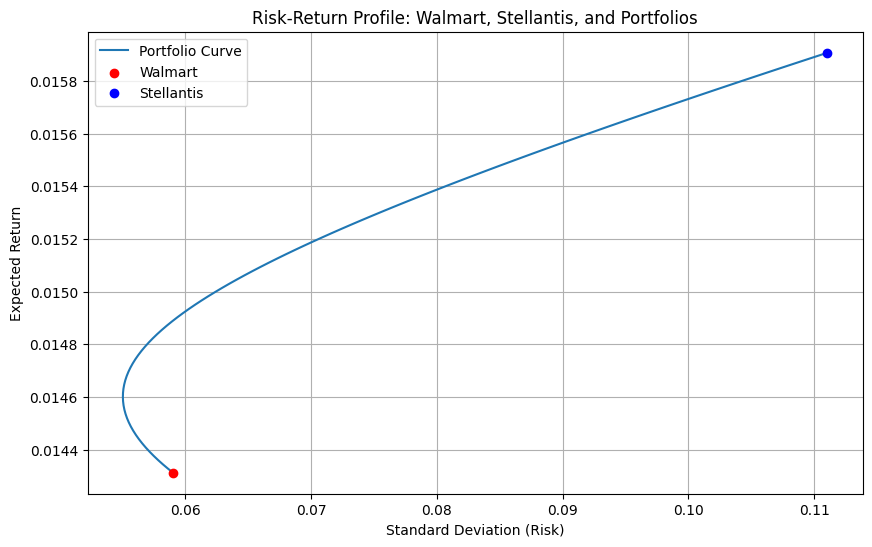

In [3]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(portfolio_stds, portfolio_returns, label='Portfolio Curve')
plt.scatter(std_walmart, avg_return_walmart, color='red', label='Walmart', zorder=5)
plt.scatter(std_stellantis, avg_return_stellantis, color='blue', label='Stellantis', zorder=5)
plt.title('Risk-Return Profile: Walmart, Stellantis, and Portfolios')
plt.xlabel('Standard Deviation (Risk)')
plt.ylabel('Expected Return')
plt.legend()
plt.grid(True)
plt.show()

## S: the best efficient portfolio

In [4]:
risk_free_rate = 0.0427/12  

portfolio_returns = np.array(portfolio_returns)
portfolio_stds = np.array(portfolio_stds)

sharpe_ratios = (portfolio_returns - risk_free_rate) / portfolio_stds

max_sharpe_idx = sharpe_ratios.argmax()
optimal_risky_portfolio_return = portfolio_returns[max_sharpe_idx]
optimal_risky_portfolio_std = portfolio_stds[max_sharpe_idx]

cml_x = np.linspace(0, max(portfolio_stds), 100)
cml_y = risk_free_rate + (optimal_risky_portfolio_return - risk_free_rate) / optimal_risky_portfolio_std * cml_x


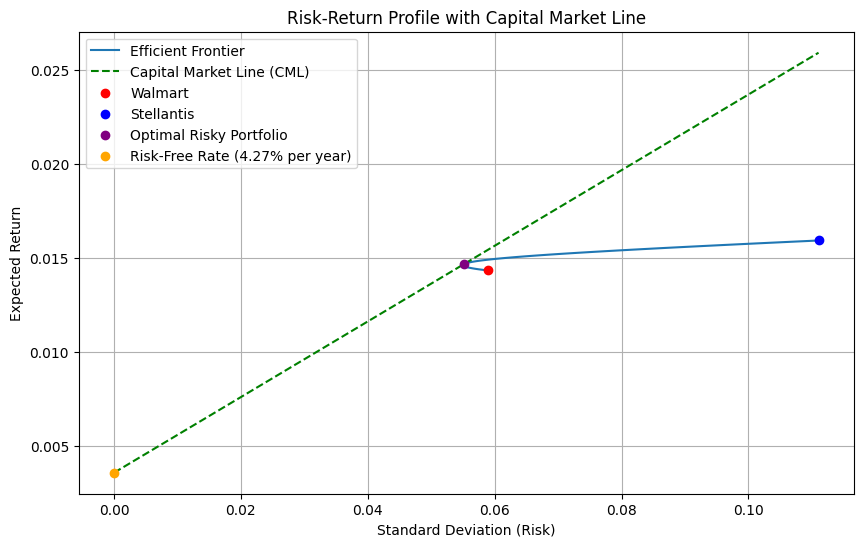

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(portfolio_stds, portfolio_returns, label='Efficient Frontier')
plt.plot(cml_x, cml_y, label='Capital Market Line (CML)', linestyle='--', color='green')
plt.scatter(std_walmart, avg_return_walmart, color='red', label='Walmart', zorder=5)
plt.scatter(std_stellantis, avg_return_stellantis, color='blue', label='Stellantis', zorder=5)
plt.scatter(optimal_risky_portfolio_std, optimal_risky_portfolio_return, color='purple', label='Optimal Risky Portfolio', zorder=5)
plt.scatter(0, risk_free_rate, color='orange', label='Risk-Free Rate (4.27% per year)', zorder=5)
plt.title('Risk-Return Profile with Capital Market Line')
plt.xlabel('Standard Deviation (Risk)')
plt.ylabel('Expected Return')
plt.legend()
plt.grid(True)
plt.show()

## But what are the specifics of S?

Below we found again S but using the statistics that refer to annual returns and not monthly.

In [6]:
annual_return_walmart = returns_df['Return_Walmart'].mean() * 12
annual_return_stellantis = returns_df['Return_Stellantis'].mean() * 12
annual_std_walmart = returns_df['Return_Walmart'].std() * np.sqrt(12)
annual_std_stellantis = returns_df['Return_Stellantis'].std() * np.sqrt(12)

cov_matrix_annual = returns_df[['Return_Walmart', 'Return_Stellantis']].cov() * 12

weights = np.linspace(0, 1, 101)
portfolio_returns = []
portfolio_stds = []
weight_combinations = []

for w in weights:
    w_walmart = w
    w_stellantis = 1 - w
    port_return = w_walmart * annual_return_walmart + w_stellantis * annual_return_stellantis
    port_variance = (
        w_walmart**2 * annual_std_walmart**2 +
        w_stellantis**2 * annual_std_stellantis**2 +
        2 * w_walmart * w_stellantis * cov_matrix_annual.iloc[0, 1]
    )
    port_std = np.sqrt(port_variance)

    portfolio_returns.append(port_return)
    portfolio_stds.append(port_std)
    weight_combinations.append((w_walmart, w_stellantis))

risk_free_rate = 0.0427

sharpe_ratios = (np.array(portfolio_returns) - risk_free_rate) / np.array(portfolio_stds)
max_sharpe_idx = sharpe_ratios.argmax()

optimal_return = portfolio_returns[max_sharpe_idx]
optimal_std = portfolio_stds[max_sharpe_idx]
optimal_weights = weight_combinations[max_sharpe_idx]

print("Optimal Expected Return:", optimal_return)
print("Optimal Standard Deviation:", optimal_std)
print("Walmart Weight:", optimal_weights[0])
print("Stellantis Weight:", optimal_weights[1])


Optimal Expected Return: 0.17576466663115362
Optimal Standard Deviation: 0.19099917917299897
Walmart Weight: 0.79
Stellantis Weight: 0.20999999999999996


In [7]:
w_share_price = 98.61
w_number_of_shares_outstanding = 8024000000.0
w_equity_value = w_share_price * w_number_of_shares_outstanding

w_total_liab_net_minority_int = 163131000000.00
w_Total_Debt= 60114000000.0
w_Net_Debt = 30030000000.0
w_interest_expense = -2728000000.0

s_share_price = 13.05
s_number_of_shares_outstanding = 2896073567.0
s_equity_value = s_share_price * s_number_of_shares_outstanding

s_Total_Debt= 37227000000.0
s_Net_Debt = 571000000.0
s_interest_expense = -1523000000.0

Prova calcolo Re:

In [8]:
Rf = 0.0424
Rm = 0.085
beta = beta_walmart
Rpremium = Rm - Rf

Re = Rf + beta * Rpremium
print(Re)

0.07289840757652971


In [9]:
walmart = {
    'equity_value': w_equity_value,  
    'debt_value': w_Net_Debt,    
    'cost_of_equity': 0.0771,  
    'cost_of_debt': w_interest_expense/w_Total_Debt,   
    'tax_rate': 0.2209           
}

stellantis = {
    'equity_value': s_equity_value,    
    'debt_value': s_Net_Debt,
    'cost_of_equity': 0.07,  
    'cost_of_debt': s_interest_expense/s_Total_Debt,    
    'tax_rate': 0.258           
}

def calculate_wacc(company):
    E = company['equity_value']
    D = company['debt_value']
    V = E + D
    #Re = company['cost_of_equity']
    Rd = company['cost_of_debt']
    Tc = company['tax_rate']
    
    wacc = ((E/V) * Re) + ((D/V) * Rd * (1 - Tc))
    return wacc

walmart_wacc = calculate_wacc(walmart)
stellantis_wacc = calculate_wacc(stellantis)

print(f"Walmart WACC: {walmart_wacc:.2%}")
print(f"Stellantis WACC: {stellantis_wacc:.2%}")


Walmart WACC: 6.89%
Stellantis WACC: 7.14%


## Walmart by comparables
https://www.macrotrends.net/stocks/charts/ROST/ross-stores/total-liabilities

In [10]:
walmart_fy_earnings = 19436000000
walmart_eps = walmart_fy_earnings / w_number_of_shares_outstanding

walmart_bv = (260823000000.0 - 16340200000.0) / w_number_of_shares_outstanding



walmart_pe = w_share_price / walmart_eps 
walmart_pb = w_share_price / walmart_bv 

print("walmart price to earning", walmart_pe) 
print("walmart price to book value", walmart_pb) 

walmart price to earning 40.71036427248405
walmart price to book value 3.2364102505370522


In [11]:
costco_stock_price = 923.65
target_stock_price = 135.50
kroger_co_stock_price = 61.53
ross_stock_price = 150.07


costco_eps = 16.59
target_eps = 8.86
kroger_eps = 2.96
ross_eps = 6.32

kroger_shares_outstanding = 696000000
costco_shares_outstanding = 445000000
target_shares_outstanding = 462000000
ross_shares_outstanding = 331000000



kroger_bv = (50505000000 - 38904000000) / kroger_shares_outstanding
costco_bv = (68994000000 - 43936000000) / costco_shares_outstanding
target_bv = (55356000000 - 41924000000) / target_shares_outstanding
ross_bv = (14905000000 - 9642000000) / ross_shares_outstanding


costco_pe = costco_stock_price/costco_eps
target_pe = target_stock_price/target_eps
kroger_pe = kroger_co_stock_price/kroger_eps
ross_pe = ross_stock_price/ross_eps

costco_pb = costco_stock_price/costco_bv
target_pb = target_stock_price/target_bv
kroger_pb = kroger_co_stock_price/kroger_bv
ross_pb = ross_stock_price/ross_bv

print(f"Costco price to book: {costco_pb:.2f}")
print(f"Costco price to earning: {costco_pe:.2f}")
print(f"Target price to book: {target_pb:.2f}")
print(f"Target price to earning: {target_pe:.2f}")
print(f"Kroger price to book: {kroger_pb:.2f}")
print(f"Kroger price to earning: {kroger_pe:.2f}")
print(f"Ross price to earning: {ross_pe:.2f}")
print(f"Ross price to book: {ross_pb:.2f}")

avg_pb = (costco_pb + ross_pb + kroger_pb ) / 3 # find best way not to fuckup  (probably add TJX)
avg_pe = (costco_pe + ross_pe + kroger_pe ) / 3
print(f"Average price to book: {avg_pb:.2f}")
print(f"Average price to earnings: {avg_pe:.2f}")

Costco price to book: 16.40
Costco price to earning: 55.68
Target price to book: 4.66
Target price to earning: 15.29
Kroger price to book: 3.69
Kroger price to earning: 20.79
Ross price to earning: 23.75
Ross price to book: 9.44
Average price to book: 9.84
Average price to earnings: 33.40


### DCF for Walmart